In [1]:
import os
os.chdir("..")   # go from notebooks/ to project root

In [2]:
from __future__ import annotations
from flamekit.datasets import SEMDataset
from flamekit.io_fronts import Case
from mpi4py import MPI
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
# -----------------------------
# Find project root robustly
# -----------------------------
def find_project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for cand in [p, *p.parents]:
        if (cand / "flamekit").is_dir():
            return cand
    raise RuntimeError("Could not find project root (folder containing 'flamekit').")

PROJECT_ROOT = find_project_root()

DATA_BASE_DIR = PROJECT_ROOT / "data"
ISOCONTOUR_BASE_DIR = PROJECT_ROOT / "isocontours"   # change if your isocontours is elsewhere


TIME_STEP = 150
MULTI_TIME_STEP = False
TIME_STEP_START = 270
TIME_STEP_END = 301
PHI = 0.40
LAT_SIZE = "400"
T_REF = 300
P_REF = 1e05

POST = True
FILE_NAME = "po_postPremix" if POST else "premix"

COMP_VEL_JACOBIAN = True
COMP_VEL_HESSIAN = False
COMP_REACTION_RATES = True
COMP_T_GRAD = True
COMP_CURV_GRAD = True
COMP_LOCAL_VEL_JACOBIAN = True


CANTERA_YAML = PROJECT_ROOT / "flamekit" / "chemical_mech" / "BurkeH2.yaml"
CANTERA_INPUTS = [str(CANTERA_YAML), None, T_REF, P_REF]


# Progress variable isolevels (0-1)
PROGRESS_LEVELS = [0.4, 0.6, 0.8, 0.9]

comm = MPI.COMM_WORLD
rank = comm.rank


In [ ]:
from flamekit.io_fields import make_case_with_base_dir
from flamekit.io_fronts import Case, folder, front_path
SCALARS = [
    "H2",
    "O2",
    "H2O",
    "H",
    "O",
    "OH",
    "HO2",
    "H2O2",
    "N2",
    "HRR",
    "curvature",
    "stretch_rate",
    "DW_FDS",
    "abs_flame_prop_vel_normal",
    "u_n",
    "u_t",
    "strain_rate",
    "tangential_strain_rate",
    "normal_strain_rate",
    "density_ratio_sigma",
    "gradT", "gradT_normal",
    "total_heat_conduction",
    "heat_conduction_normal",
    "heat_conduction_tangential",
    "FDS_src_term",
    "FDS_diffusion_term",
    "FDS_diff_velocity_term",
    "H2_diffusion_total",
    "O2_diffusion_total",
    "H_diffusion_total",
    "vorticity",
]


# ============================================================
# Case (new I/O)
# ============================================================



def _case_paths(case: Case, data_base_dir: Path, isocontour_base_dir: Path, iso: float):
    data_case = make_case_with_base_dir(case, data_base_dir)
    out_case = make_case_with_base_dir(case, isocontour_base_dir)
    folder_name = folder(data_case)
    save_dir = folder(out_case)
    out_path = front_path(out_case, float(iso))
    return folder_name, save_dir, out_path

comm = MPI.COMM_WORLD
rank = comm.rank

if MULTI_TIME_STEP:
    for TIME_STEP in range(TIME_STEP_START, TIME_STEP_END+1):
        # Minimal Case (as per your template)
        case = Case(
            base_dir=ISOCONTOUR_BASE_DIR,  # not used for extraction, but part of the unified convention
            phi=PHI,
            lat_size=LAT_SIZE,
            time_step=TIME_STEP,
            post=POST,
        )
        # derive paths using unified Case logic
        folder_name, save_dir, _ = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, PROGRESS_LEVELS[0])

        # Create output directory on rank 0
        if rank == 0:
            save_dir.mkdir(parents=True, exist_ok=True)

        # Create dataset
        ds = SEMDataset(
            file_name=FILE_NAME,
            folder_name=folder_name,          # <- can be Path now
            time_step=case.time_step,
            comm=comm,
            scalar_names=SCALARS,
        )


        # Create dataframe (as in your original script)
        df = ds.create_dataframe(
            compute_vel_jacobian=COMP_VEL_JACOBIAN,
            compute_vel_hessian=COMP_VEL_HESSIAN,
            compute_reaction_rates=COMP_REACTION_RATES,
            compute_T_grad=COMP_T_GRAD,
            compute_curv_grad=COMP_CURV_GRAD,
            cantera_inputs=CANTERA_INPUTS,
            compute_progress_var=True,
            phi=PHI,
        )

        # Plot on rank 0 only
        if rank == 0:
            fig, ax = plt.subplots(figsize=(8, 10), dpi=150)

        # Extract + save + plot (rank 0 handles IO/plotting)
        for iso in PROGRESS_LEVELS:
            front = ds.extract_flame_front(c_level=iso, scalar_name="progress_var")

            if rank == 0:
                _, save_dir, out_path = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, float(iso))
                front.to_csv(out_path, index=False)

                ax.scatter(
                    front["x"],
                    front["y"],
                    s=0.01,
                    alpha=1.0,
                    label=fr"$c={iso}$",
                )

        if rank == 0:
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.legend(markerscale=2, fontsize=8)
            ax.grid(True)
            plt.tight_layout()
            plt.show()
else:
# Minimal Case 
    case = Case(
        base_dir=ISOCONTOUR_BASE_DIR,  # not used for extraction, but part of the unified convention
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=TIME_STEP,
        post=POST,
    )
    # derive paths using unified Case logic
    folder_name, save_dir, _ = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, PROGRESS_LEVELS[0])

    # Create output directory on rank 0
    if rank == 0:
        save_dir.mkdir(parents=True, exist_ok=True)

    # Create dataset
    ds = SEMDataset(
        file_name=FILE_NAME,
        folder_name=folder_name,          # <- can be Path now
        time_step=case.time_step,
        comm=comm,
        scalar_names=SCALARS,
    )


    # Create dataframe 
    df = ds.create_dataframe(
        compute_vel_jacobian=COMP_VEL_JACOBIAN,
        compute_vel_hessian=COMP_VEL_HESSIAN,
        compute_reaction_rates=COMP_REACTION_RATES,
        compute_T_grad=COMP_T_GRAD,
        compute_curv_grad=COMP_CURV_GRAD,
        compute_local_vel_jacobian=COMP_LOCAL_VEL_JACOBIAN,
        cantera_inputs=CANTERA_INPUTS,
        compute_progress_var=True,
        phi=PHI,
    )

    # Plot on rank 0 only
    if rank == 0:
        fig, ax = plt.subplots(figsize=(8, 10), dpi=150)

    # Extract + save + plot (rank 0 handles IO/plotting)
    for iso in PROGRESS_LEVELS:
        front = ds.extract_flame_front(c_level=iso, scalar_name="progress_var")

        if rank == 0:
            _, save_dir, out_path = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, float(iso))
            front.to_csv(out_path, index=False)

            ax.scatter(
                front["x"],
                front["y"],
                s=0.01,
                alpha=1.0,
                label=fr"$c={iso}$",
            )

    if rank == 0:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend(markerscale=50, fontsize=8)
        ax.grid(True)
        plt.tight_layout()
        plt.show()


2026-01-01 18:47:14,831 - Mesh - INFO - Initializing empty Mesh object.
2026-01-01 18:47:14,831 - Field - INFO - Initializing empty Field object
2026-01-01 18:47:14,833 - pynekread - INFO - Reading file: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/phi0.40/h400x400_ref/po_postPremix0.f00001
2026-01-01 18:47:15,035 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2026-01-01 18:47:15,036 - Mesh - INFO - Initializing common attributes.
2026-01-01 18:47:15,036 - Mesh - INFO - Getting vertices
2026-01-01 18:47:15,113 - Mesh - INFO - Getting edge centers
2026-01-01 18:47:15,764 - Mesh - INFO - Facet centers not available for 2D
2026-01-01 18:47:15,765 - Mesh - INFO - Mesh object initialized.
2026-01-01 18:47:15,765 - Mesh - INFO - Mesh data is of type: float64
2026-01-01 18:47:15,766 - Mesh - INFO - Elapsed time: 0.730387707s
2026-01-01 18:47:15,766 - pynekread - INFO - Reading field data
2026-01-01 18:47:15,766 - pynekread - INFO - Overwriting fld object

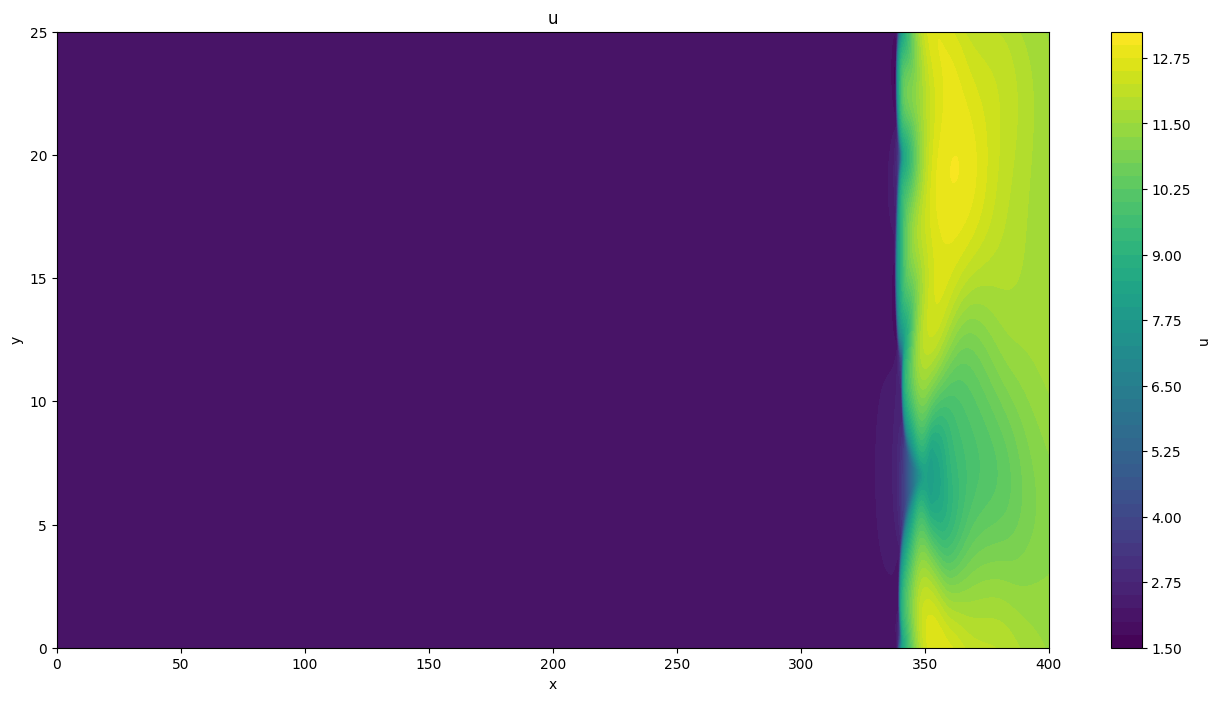

In [5]:
plot_var = "u"
df_sub = df
plt.figure(figsize=(16, 8))
cf = plt.tricontourf(
    df_sub["x"], df_sub["y"], df_sub[plot_var],
    levels=50,
)
plt.xlabel("x")
plt.ylabel("y")
plt.title(str(plot_var))
plt.colorbar(cf, label=plot_var)
plt.show()